# Промежуточная аттестация №1. Глазков Олег Игоревич

## Задание 1.

Предварительно загрузите данные в любую SQL-реляционную базу данных и затем используйте эти данные с загрузкой всоответствующий dataframe.

### Выполняем подключение к БД PostgreSQL и записываем в БД датасет из csv-файла

БД развернута в Яндекс.Облаке.

Подключение осуществляется через хост, порт, логин и пароль, с помощью модуля `database_config`

In [130]:
import pandas as pd
from sqlalchemy import create_engine

# импортирую модуль с подключениями к БД
from database_config import MY_DWH

# инициализирую переменные - параметры подключения
host, port, user, password, database = MY_DWH()

# создаю движок подключения
engine = create_engine(f"postgresql://{user}:{password}@{host}:{port}/{database}")

### Описание датасета

* 'player_name'         - Имя игрока,
* 'team_abbreviation'   - Сокращенное наименование команды,
* 'age'                 - Возраст игрока,
* 'player_height'       - Рост игрока,
* 'player_weight'       - Вес игрока,
* 'college'             - Учебное заведение игрока,
* 'country'             - Страна игрока,
* 'draft_year'          - Год найма (драфта),
* 'draft_round'         - Раунд найма (драфта),
* 'draft_number'        - Номер игорка в найме (драфте),
* 'gp'                  - Количество игр игрока за сезон,
* 'pts'                 - Среднее число очков за игру,
* 'reb'                 - Среднее число подборов за игру,
* 'ast'                 - Среднее число голевых пасов за игру,
* 'net_rating'          - Разница очков команды за 100 владений, пока игрок находится на площадке,
* 'oreb_pct'            - Процент доступных подборов в нападении, которые игрок захватил, находясь на площадке,
* 'dreb_pct'            - Процент доступных подборов в защите, которые игрок захватил, находясь на площадке,
* 'usg_pct'             - Процент командных игр, использованных игроком, пока он находился на площадке,
* 'ts_pct'              - Мера эффективности броска игрока, учитывающая штрафные броски, 2- и 3-очковые броски,
* 'ast_pct'             - Процент бросков с игры товарищей по команде, которым игрок ассистировал, находясь на площадке,
* 'season'              - Сезон

Импортирую датасет из файла `csv`, отсекаю "лишний" столбец с индексами строк, а затем записываю в БД с помощью функции `to_sql()`

In [131]:
df = pd.read_csv('dataset.csv', sep=',')
df = df.iloc[:,1:]
df.to_sql('basketball', engine, if_exists='replace', index=False, schema='db02')

305

### Производим чтение из БД PostgreSQL

In [132]:
df = pd.read_sql_query('''SELECT * FROM db02.basketball''', engine)
df.head()

player_name team_abbreviation   age  player_height  player_weight  \
0      Dennis Rodman               CHI  36.0         198.12      99.790240   
1  Dwayne Schintzius               LAC  28.0         215.90     117.933920   
2       Earl Cureton               TOR  39.0         205.74      95.254320   
3        Ed O'Bannon               DAL  24.0         203.20     100.697424   
4        Ed Pinckney               MIA  34.0         205.74     108.862080   

                       college country draft_year draft_round draft_number  \
0  Southeastern Oklahoma State     USA       1986           2           27   
1                      Florida     USA       1990           1           24   
2                Detroit Mercy     USA       1979           3           58   
3                         UCLA     USA       1995           1            9   
4                    Villanova     USA       1985           1           10   

   ...  pts   reb  ast  net_rating  oreb_pct  dreb_pct  usg_pct  ts_pct  \
0  ...  5.7  16.1  3.1        16.1     0.186     0.323    0.100   0.479   
1  ...  2.3   1.5  0.3        12.3     0.078     0.151    0.175   0.430   
2  ...  0.8   1.0  0.4        -2.1     0.105     0.102    0.103   0.376   
3  ...  3.7   2.3  0.6        -8.7     0.060     0.149    0.167   0.399   
4  ...  2.4   2.4  0.2       -11.2     0.109     0.179    0.127   0.611   

   ast_pct   season  
0    0.113  1996-97  
1    0.048  1996-97  
2    0.148  1996-97  
3    0.077  1996-97  
4    0.040  1996-97  

[5 rows x 21 columns]

## Задание 2.

Используя:
* Линейную регрессию
* Логистическую регрессию
* SVM  - укажите зависимость роста(`player_height`) от веса(`player_weight`) игрока для уникальных игроков всех команд по всем сезонам. Постройте визуализацию используя библиотеки Matplotlib/Seaborn. По каждому из методов выведите оценку score модели

### Импорт библиотек

In [133]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVR, SVC
from sklearn.metrics import r2_score, accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder

### Предварительный анализ датасета

In [134]:
df.head()

player_name team_abbreviation   age  player_height  player_weight  \
0      Dennis Rodman               CHI  36.0         198.12      99.790240   
1  Dwayne Schintzius               LAC  28.0         215.90     117.933920   
2       Earl Cureton               TOR  39.0         205.74      95.254320   
3        Ed O'Bannon               DAL  24.0         203.20     100.697424   
4        Ed Pinckney               MIA  34.0         205.74     108.862080   

                       college country draft_year draft_round draft_number  \
0  Southeastern Oklahoma State     USA       1986           2           27   
1                      Florida     USA       1990           1           24   
2                Detroit Mercy     USA       1979           3           58   
3                         UCLA     USA       1995           1            9   
4                    Villanova     USA       1985           1           10   

   ...  pts   reb  ast  net_rating  oreb_pct  dreb_pct  usg_pct  ts_pct  \
0  ...  5.7  16.1  3.1        16.1     0.186     0.323    0.100   0.479   
1  ...  2.3   1.5  0.3        12.3     0.078     0.151    0.175   0.430   
2  ...  0.8   1.0  0.4        -2.1     0.105     0.102    0.103   0.376   
3  ...  3.7   2.3  0.6        -8.7     0.060     0.149    0.167   0.399   
4  ...  2.4   2.4  0.2       -11.2     0.109     0.179    0.127   0.611   

   ast_pct   season  
0    0.113  1996-97  
1    0.048  1996-97  
2    0.148  1996-97  
3    0.077  1996-97  
4    0.040  1996-97  

[5 rows x 21 columns]

In [135]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12305 entries, 0 to 12304
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   player_name        12305 non-null  object 
 1   team_abbreviation  12305 non-null  object 
 2   age                12305 non-null  float64
 3   player_height      12305 non-null  float64
 4   player_weight      12305 non-null  float64
 5   college            10516 non-null  object 
 6   country            12305 non-null  object 
 7   draft_year         12305 non-null  object 
 8   draft_round        12305 non-null  object 
 9   draft_number       12305 non-null  object 
 10  gp                 12305 non-null  int64  
 11  pts                12305 non-null  float64
 12  reb                12305 non-null  float64
 13  ast                12305 non-null  float64
 14  net_rating         12305 non-null  float64
 15  oreb_pct           12305 non-null  float64
 16  dreb_pct           123

In [136]:
df.columns

Index(['player_name', 'team_abbreviation', 'age', 'player_height',
       'player_weight', 'college', 'country', 'draft_year', 'draft_round',
       'draft_number', 'gp', 'pts', 'reb', 'ast', 'net_rating', 'oreb_pct',
       'dreb_pct', 'usg_pct', 'ts_pct', 'ast_pct', 'season'],
      dtype='object')

In [137]:
df.isnull().sum()

player_name             0
team_abbreviation       0
age                     0
player_height           0
player_weight           0
college              1789
country                 0
draft_year              0
draft_round             0
draft_number            0
gp                      0
pts                     0
reb                     0
ast                     0
net_rating              0
oreb_pct                0
dreb_pct                0
usg_pct                 0
ts_pct                  0
ast_pct                 0
season                  0
dtype: int64

In [138]:
df.describe()

age  player_height  player_weight            gp           pts  \
count  12305.000000   12305.000000   12305.000000  12305.000000  12305.000000   
mean      27.084518     200.611602     100.369926     51.290532      8.172775   
std        4.335868       9.146321      12.477150     25.095909      5.974957   
min       18.000000     160.020000      60.327736      1.000000      0.000000   
25%       24.000000     193.040000      90.718400     31.000000      3.600000   
50%       26.000000     200.660000      99.790240     57.000000      6.700000   
75%       30.000000     208.280000     108.862080     73.000000     11.500000   
max       44.000000     231.140000     163.293120     85.000000     36.100000   

                reb           ast    net_rating      oreb_pct      dreb_pct  \
count  12305.000000  12305.000000  12305.000000  12305.000000  12305.000000   
mean       3.559155      1.813986     -2.255733      0.054473      0.141014   
std        2.483550      1.794155     12.673254      0.043599      0.062704   
min        0.000000      0.000000   -250.000000      0.000000      0.000000   
25%        1.800000      0.600000     -6.400000      0.021000      0.096000   
50%        3.000000      1.200000     -1.300000      0.041000      0.131000   
75%        4.700000      2.400000      3.200000      0.084000      0.180000   
max       16.300000     11.700000    300.000000      1.000000      1.000000   

            usg_pct        ts_pct       ast_pct  
count  12305.000000  12305.000000  12305.000000  
mean       0.184891      0.511060      0.131358  
std        0.053390      0.101163      0.094483  
min        0.000000      0.000000      0.000000  
25%        0.149000      0.480000      0.066000  
50%        0.181000      0.524000      0.103000  
75%        0.217000      0.561000      0.178000  
max        1.000000      1.500000      1.000000

In [139]:
# Посмотрим какие сезоны представлены в датасете
df['season'].unique()

array(['1996-97', '1997-98', '1998-99', '1999-00', '2000-01', '2001-02',
       '2002-03', '2003-04', '2004-05', '2005-06', '2006-07', '2007-08',
       '2008-09', '2009-10', '2010-11', '2011-12', '2012-13', '2013-14',
       '2014-15', '2015-16', '2016-17', '2017-18', '2018-19', '2019-20',
       '2020-21', '2021-22'], dtype=object)

In [140]:
df_season_10_11 = df[df['season'] == '2010-11']

In [141]:
fig = px.scatter(df_season_10_11, x='country', y='age', color='country', hover_data=['player_name', 'team_abbreviation'])
fig.update_layout(title='Распределение возраста игроков по странам - сезон 2010-11')
fig.show()

In [142]:
# Удаляем столбцы с нечисловыми данными
df_copy = df.copy()
df_copy = df.drop(columns=['player_name', 'team_abbreviation', 'country', 'college', 'season',\
                      'draft_year', 'draft_number', 'draft_round'])

In [143]:
# Построим матрицу корреляции
correlation_matrix = df_copy.corr()
fig = px.imshow(correlation_matrix,
                title='Матрица корреляции',
                labels=dict(color="Корреляция"),
                x=correlation_matrix.index,
                y=correlation_matrix.columns,
                color_continuous_scale='Viridis',
                width=900,
                height=600)
for i in range(len(correlation_matrix.index)):
    for j in range(len(correlation_matrix.columns)):
        fig.add_annotation(x=correlation_matrix.index[i], y=correlation_matrix.columns[j],
                           text=str(round(correlation_matrix.iloc[i, j], 2)),
                           showarrow=False, font=dict(color='white', size=11))
fig.show()

In [144]:
# Взглянем на зависимость роста и веса игрока
fig = px.scatter(df, x='player_weight', y='player_height',
                 title='Зависимость роста от веса игрока',
                 labels={'player_weight': 'Вес игрока', 'player_height': 'Рост игрока'},
                 width=900,
                 height=600)

fig.show()

In [145]:
print('Количество уникальных игроков', df['player_name'].nunique())

Количество уникальных игроков 2463


In [146]:
df_dd = df.drop_duplicates(subset=['player_name'])
df_dd.shape

(2463, 21)

In [147]:
# Разделение данных на обучающий и тестовый наборы
X = df_dd.loc[:, ['player_weight']].values
y = df_dd.loc[:, ['player_height']].values

In [148]:
X

array([[ 99.79024 ],
       [117.93392 ],
       [ 95.25432 ],
       ...,
       [ 99.79024 ],
       [ 92.98636 ],
       [112.490816]])

In [149]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [150]:
X_train

array([[ 99.79024 ],
       [ 95.25432 ],
       [122.923432],
       ...,
       [ 99.79024 ],
       [108.86208 ],
       [104.32616 ]])

### Масштабирование данных

In [151]:
# Масштабирование данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [152]:
X_train_scaled

array([[ 0.08241889],
       [-0.28449922],
       [ 1.95370125],
       ...,
       [ 0.08241889],
       [ 0.81625511],
       [ 0.449337  ]])

### Линейная регрессия

In [153]:
# Линейная регрессия
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)
lin_reg_score = lin_reg.score(X_test_scaled, y_test)
print("Линейная регрессия - Score:", lin_reg_score)

Линейная регрессия - Score: 0.6089720228292801


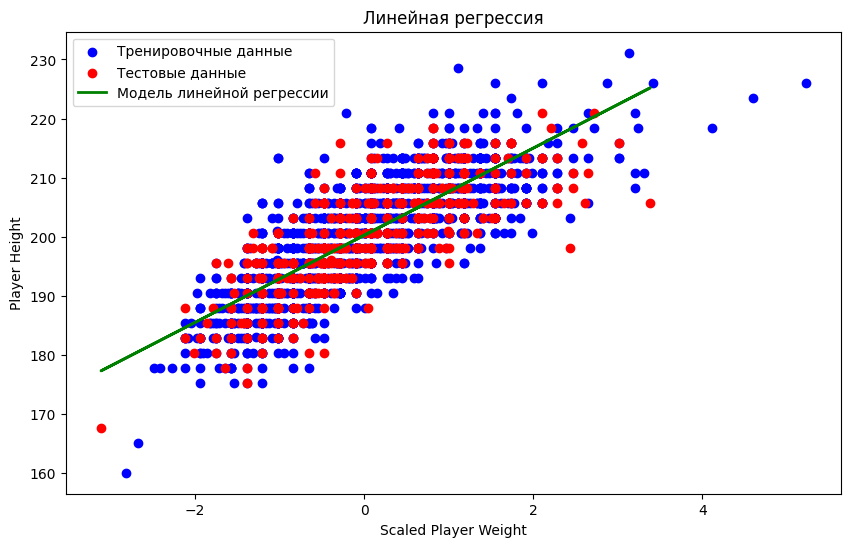

In [154]:
# Построение визуализации для линейной регрессии
plt.figure(figsize=(10, 6))
plt.scatter(X_train_scaled, y_train, color='blue', label='Тренировочные данные')
plt.scatter(X_test_scaled, y_test, color='red', label='Тестовые данные')
plt.plot(X_test_scaled, lin_reg.predict(X_test_scaled), color='green', linewidth=2,
         label='Модель линейной регрессии')
plt.title('Линейная регрессия')
plt.xlabel('Scaled Player Weight')
plt.ylabel('Player Height')
plt.legend()
plt.show()

### Метод опорных векторов

In [155]:
# SVM
svm = SVR(kernel='linear')
svm.fit(X_train_scaled, y_train.ravel())
svm_score = svm.score(X_test_scaled, y_test)
print("SVM Score:", svm_score)

SVM Score: 0.6063870518378045


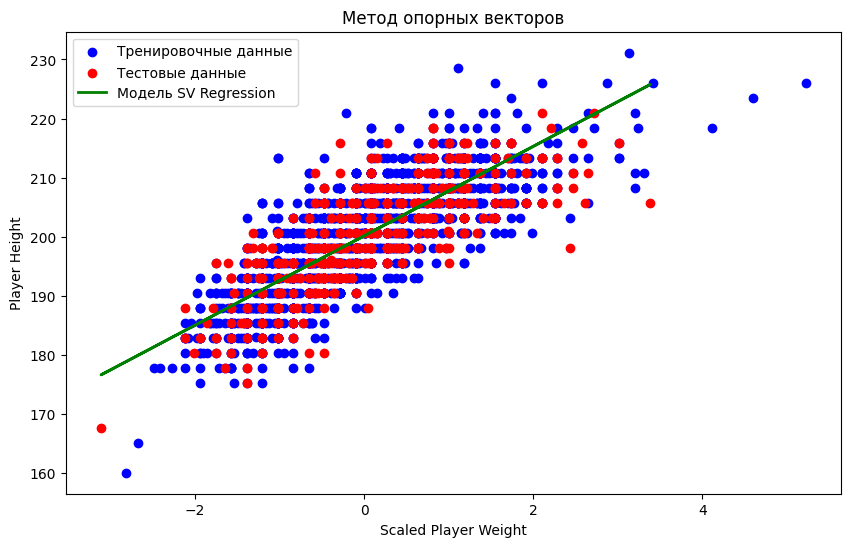

In [156]:
# Построение визуализации для SVM
plt.figure(figsize=(10, 6))
plt.scatter(X_train_scaled, y_train, color='blue', label='Тренировочные данные')
plt.scatter(X_test_scaled, y_test, color='red', label='Тестовые данные')
plt.plot(X_test_scaled, svm.predict(X_test_scaled), color='green', linewidth=2, label='Модель SV Regression')
plt.title('Метод опорных векторов')
plt.xlabel('Scaled Player Weight')
plt.ylabel('Player Height')
plt.legend()
plt.show()

Постройка графика plotly.express

In [157]:
import numpy as np
import plotly.graph_objects as go
# Преобразование тренировочных и тестовых данных в одномерные массивы
X_train_scaled = X_train_scaled.flatten()
y_train = y_train.flatten()
X_test_scaled = X_test_scaled.flatten()
y_test = y_test.flatten()

# Создание scatter plot для тренировочных и тестовых данных
train_scatter = go.Scatter(x=X_train_scaled, y=y_train, mode='markers', marker=dict(color='blue'), name='Тренировочные данные')
test_scatter = go.Scatter(x=X_test_scaled, y=y_test, mode='markers', marker=dict(color='red'), name='Тестовые данные')

# Построение линии модели
X_line = np.linspace(X_test_scaled.min(), X_test_scaled.max(), 100)
y_line = svm.predict(X_line.reshape(-1, 1))
model_line = go.Scatter(x=X_line, y=y_line, mode='lines', line=dict(color='green', width=2), name='Модель SV Regression')

# Настройка макета и отображение графика
layout = go.Layout(title='Метод опорных векторов', xaxis=dict(title='Scaled Player Weight'), yaxis=dict(title='Player Height'))
fig = go.Figure(data=[train_scatter, test_scatter, model_line], layout=layout)
fig.show()

### Логистическая регрессия

Логистическая регрессия не подходит для этой задачи, так как зависимая переменная (рост или вес игрока) непрерывна. Логистическая регрессия используется для бинарной классификации. Для построения модели Логистической модели датасет требуется кластеризировать - определить количество классов. Наилучшим способом будет выполнить K-means кластеризацию, чтобы найти значение - `k`

Для этого масштабирую весь датафрейм - только с числовыми данными - возьму датасет `df_copy`, который готовил ранее для построения [Матрицы корреляции](
https://colab.research.google.com/drive/1YUAF3scacqVVNAaEtq5v6UIq-7ersyOa#scrollTo=sFZr0UTnIq9P&line=2&uniqifier=1)

In [158]:
scaler = StandardScaler()
df_standart = pd.DataFrame(data = scaler.fit_transform(df_copy),
                           index = df_copy.index, columns = df_copy.columns)
df_standart

age  player_height  player_weight        gp       pts       reb  \
0      2.056300      -0.272427      -0.046462  0.147818 -0.413873  5.049770   
1      0.211150       1.671603       1.407750 -1.446132 -0.982938 -0.829151   
2      2.748231       0.560729      -0.410015 -1.685225 -1.233996 -1.030484   
3     -0.711425       0.283010       0.026249  0.506456 -0.748617 -0.507019   
4      1.595012       0.560729       0.680644 -0.967947 -0.966201 -0.466752   
...         ...            ...            ...       ...       ...       ...   
12300  1.133725       0.560729       0.862421 -1.366435 -0.095867 -0.386219   
12301 -0.711425      -0.827864      -0.446370 -1.326586  0.439724 -0.345952   
12302  0.211150      -0.827864      -0.046462  0.785398  0.657308  0.096980   
12303 -0.942069      -0.550145      -0.591791 -1.565679 -1.183785 -0.668085   
12304 -0.711425       0.838448       0.971486 -1.924317 -0.698406 -0.225153   

            ast  net_rating  oreb_pct  dreb_pct   usg_pct    ts_pct   ast_pct  
0      0.716809    1.448442  3.016889  2.902412 -1.590093 -0.316927 -0.194309  
1     -0.843878    1.148586  0.539655  0.159261 -0.185266 -0.801313 -0.882293  
2     -0.788139    0.012289  1.158964 -0.622218 -1.533900 -1.335127  0.176145  
3     -0.676661   -0.508514  0.126783  0.127364 -0.335114 -1.107762 -0.575346  
4     -0.899617   -0.705788  1.250713  0.605821 -1.084355  0.987949 -0.966968  
...         ...         ...       ...       ...       ...       ...       ...  
12300 -0.230751    0.533092  0.103845 -0.829549  0.226817  0.355282 -0.162556  
12301  2.054540   -0.240222 -1.020085 -0.398938  1.500526  0.058719  3.351458  
12302  2.277495    0.911858 -0.836586 -0.765755 -0.110342  0.286084  1.202829  
12303 -0.676661    0.635674  0.402031 -0.526526 -1.852327 -2.284128 -0.660021  
12304 -1.011094   -4.272499  0.929590 -0.255401 -0.691004 -0.059906 -1.390344  

[12305 rows x 13 columns]

С помощью Метода `K-means` попытаюсь найти оптимальное значение `k`

#### Каменистая осыпь

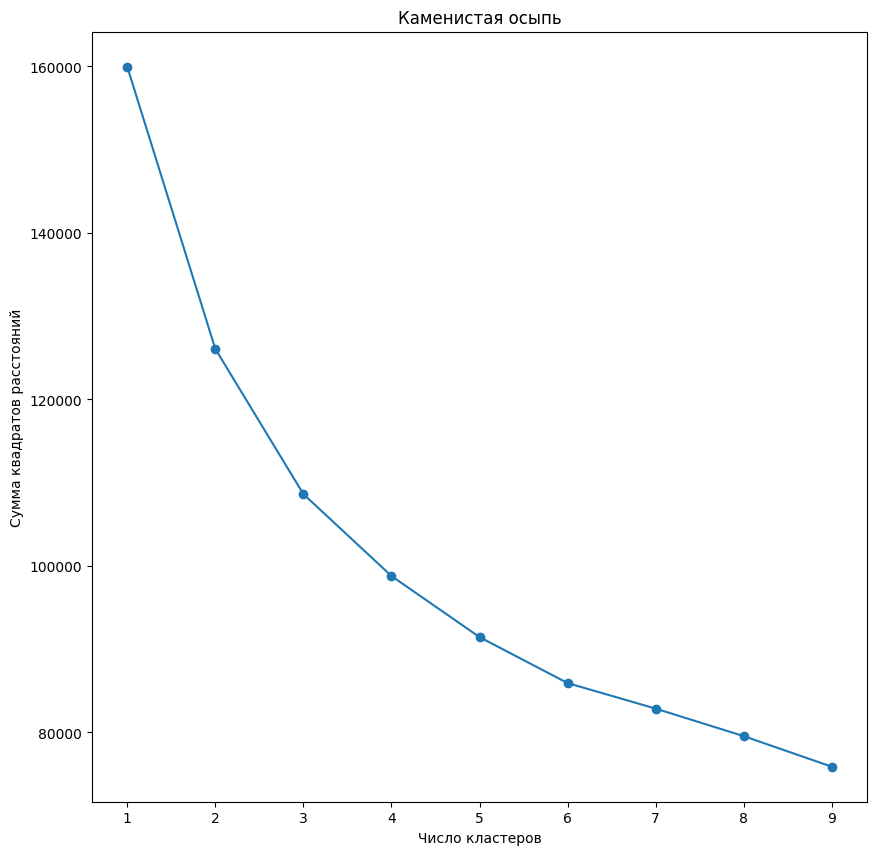

In [159]:
from sklearn.cluster import KMeans

K = range(1, 10)
models = [KMeans(n_clusters = k, random_state = 42, init='k-means++',
                 n_init = 'auto', max_iter = 300).fit(df_standart) for k in K]
dist = [model.inertia_ for model in models]

plt.figure(figsize=(10,10))
plt.plot(K, dist, marker='o')
plt.xlabel('Число кластеров')
plt.ylabel('Сумма квадратов расстояний')
plt.title('Каменистая осыпь')
plt.show()

#### Коэффициент силуэта

Посмотрим на коэффициент силуэта (`silhouette_score`) - более высокий показатель коэффициента силуэта относится к модели с лучше определенными кластерами. Коэффициент силуэта определяется для каждого образца и состоит из двух баллов: a : Среднее расстояние между образцом и всеми другими точками того же класса. b : Среднее расстояние между образцом и всеми другими точками в следующем ближайшем кластере.

Таким образом я хочу найти оптимальное значение `k`

In [160]:
from sklearn.metrics import silhouette_score

range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=42, init='k-means++',
                       n_init = 'auto', max_iter = 300)
    cluster_labels = clusterer.fit_predict(df_standart)
    silhouette_avg = silhouette_score(df_standart, cluster_labels)
    print(
        "Для кластеров (n_clusters) =",
        n_clusters,
        "Коэффициент силуэта:",
        silhouette_avg,
    )

Для кластеров (n_clusters) = 2 Коэффициент силуэта: 0.2089587032709017
Для кластеров (n_clusters) = 3 Коэффициент силуэта: 0.18496136871833455
Для кластеров (n_clusters) = 4 Коэффициент силуэта: 0.16973629135720528
Для кластеров (n_clusters) = 5 Коэффициент силуэта: 0.15492688774569197
Для кластеров (n_clusters) = 6 Коэффициент силуэта: 0.15119335245765703
Для кластеров (n_clusters) = 7 Коэффициент силуэта: 0.1429497132880234
Для кластеров (n_clusters) = 8 Коэффициент силуэта: 0.13578722490186723


#### Построение модели Логистической регрессии

Наиболее высокий коэффициент силуэта при `n_clusters = 2` Соответственно для модели Логистической регрессии будем использовать 2 класса

In [161]:
df_lr = df_dd.copy() # возьмем датасет только с уникальными игроками
df_lr['player_height'] = np.round(df_lr['player_height'])
df_lr['class_height'] = pd.cut(df_lr['player_height'], bins=2, labels=[0, 1])
df_lr['class_height'] = df_lr['class_height'].astype('int')
df_lr.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2463 entries, 0 to 12304
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   player_name        2463 non-null   object 
 1   team_abbreviation  2463 non-null   object 
 2   age                2463 non-null   float64
 3   player_height      2463 non-null   float64
 4   player_weight      2463 non-null   float64
 5   college            2118 non-null   object 
 6   country            2463 non-null   object 
 7   draft_year         2463 non-null   object 
 8   draft_round        2463 non-null   object 
 9   draft_number       2463 non-null   object 
 10  gp                 2463 non-null   int64  
 11  pts                2463 non-null   float64
 12  reb                2463 non-null   float64
 13  ast                2463 non-null   float64
 14  net_rating         2463 non-null   float64
 15  oreb_pct           2463 non-null   float64
 16  dreb_pct           2463 non-

In [162]:
X = df_lr[['player_weight', 'player_height']].values
y = df_lr['class_height'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [163]:
X_train

array([[ 99.79024 , 211.      ],
       [ 95.25432 , 203.      ],
       [122.923432, 213.      ],
       ...,
       [ 99.79024 , 206.      ],
       [108.86208 , 211.      ],
       [104.32616 , 208.      ]])

In [164]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled

array([[ 0.08241889,  1.17936703],
       [-0.28449922,  0.30543321],
       [ 1.95370125,  1.39785048],
       ...,
       [ 0.08241889,  0.63315839],
       [ 0.81625511,  1.17936703],
       [ 0.449337  ,  0.85164185]])

In [165]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_scaled, y_train)
score = lr.score(X_test_scaled, y_test)
print(f'Логистическая регрессия score: {score}')

Логистическая регрессия score: 1.0


<ipython-input-166-6408dbc76780>:23: UserWarning:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.



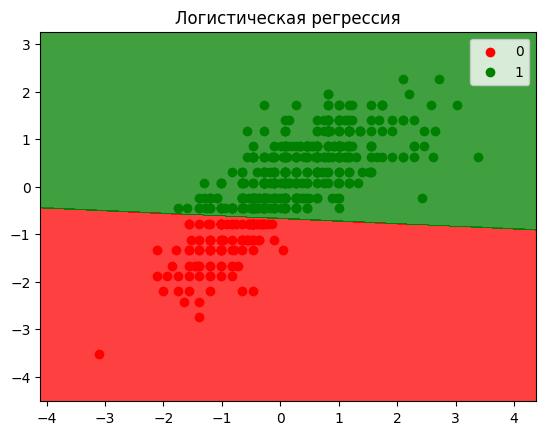

In [166]:
# Построим визуализацию
from matplotlib.colors import ListedColormap

X_set, y_set = X_test_scaled, y_test

X1, X2 = np.meshgrid(np.arange(start = X_set[:,0].min() - 1,
                               stop = X_set[:,0].max() + 1,
                               step=0.01),
                     np.arange(start = X_set[:,1].min() - 1,
                               stop = X_set[:,1].max() + 1,
                               step=0.01))

# X1.ravel()
plt.contourf(X1, X2, lr.predict(
    np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
    alpha=0.75,
    cmap= ListedColormap(('red', 'green'))
    )
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())

for i, j in enumerate(np.unique(y_set)):
  plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
              c=ListedColormap(('red', 'green'))(i), label=j)

plt.title('Логистическая регрессия')
plt.legend()
plt.show()

## Задание 3.

Используя алгоритм Дерева Принятия Решения попробуйте определить название команды(`team_abbreviation`) как целевое значение функции(`Y`) за сезон 2010-11 от следующих атрибутов(`𝑋𝑖`):
* Среднее `pts` всех игроков команды за сезон
* Среднее `reb` всех игроков команды за сезон
* Среднее `ast` всех игроков команды за сезон
* Среднее `player_height` всех игроков команды за сезон
* Среднее `player_width` всех игроков команды за сезон

Импорт необходимых библиотек

In [167]:
import pydotplus
import graphviz
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score

In [168]:
# Фильтрация данных для сезона 2010-11
data_2010_11 = df[df['season'] == '2010-11']

In [169]:
# Создание предикторов (X) и целевой переменной (Y)
X = data_2010_11[['pts', 'reb', 'ast', 'player_height', 'player_weight']].groupby(data_2010_11['team_abbreviation']).mean(numeric_only=True)
Y = X.index

In [170]:
# Разделение данных на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [171]:
# Обучение модели дерева принятия решений
dt_classifier = DecisionTreeClassifier(criterion='gini', random_state=42)
dt_classifier.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

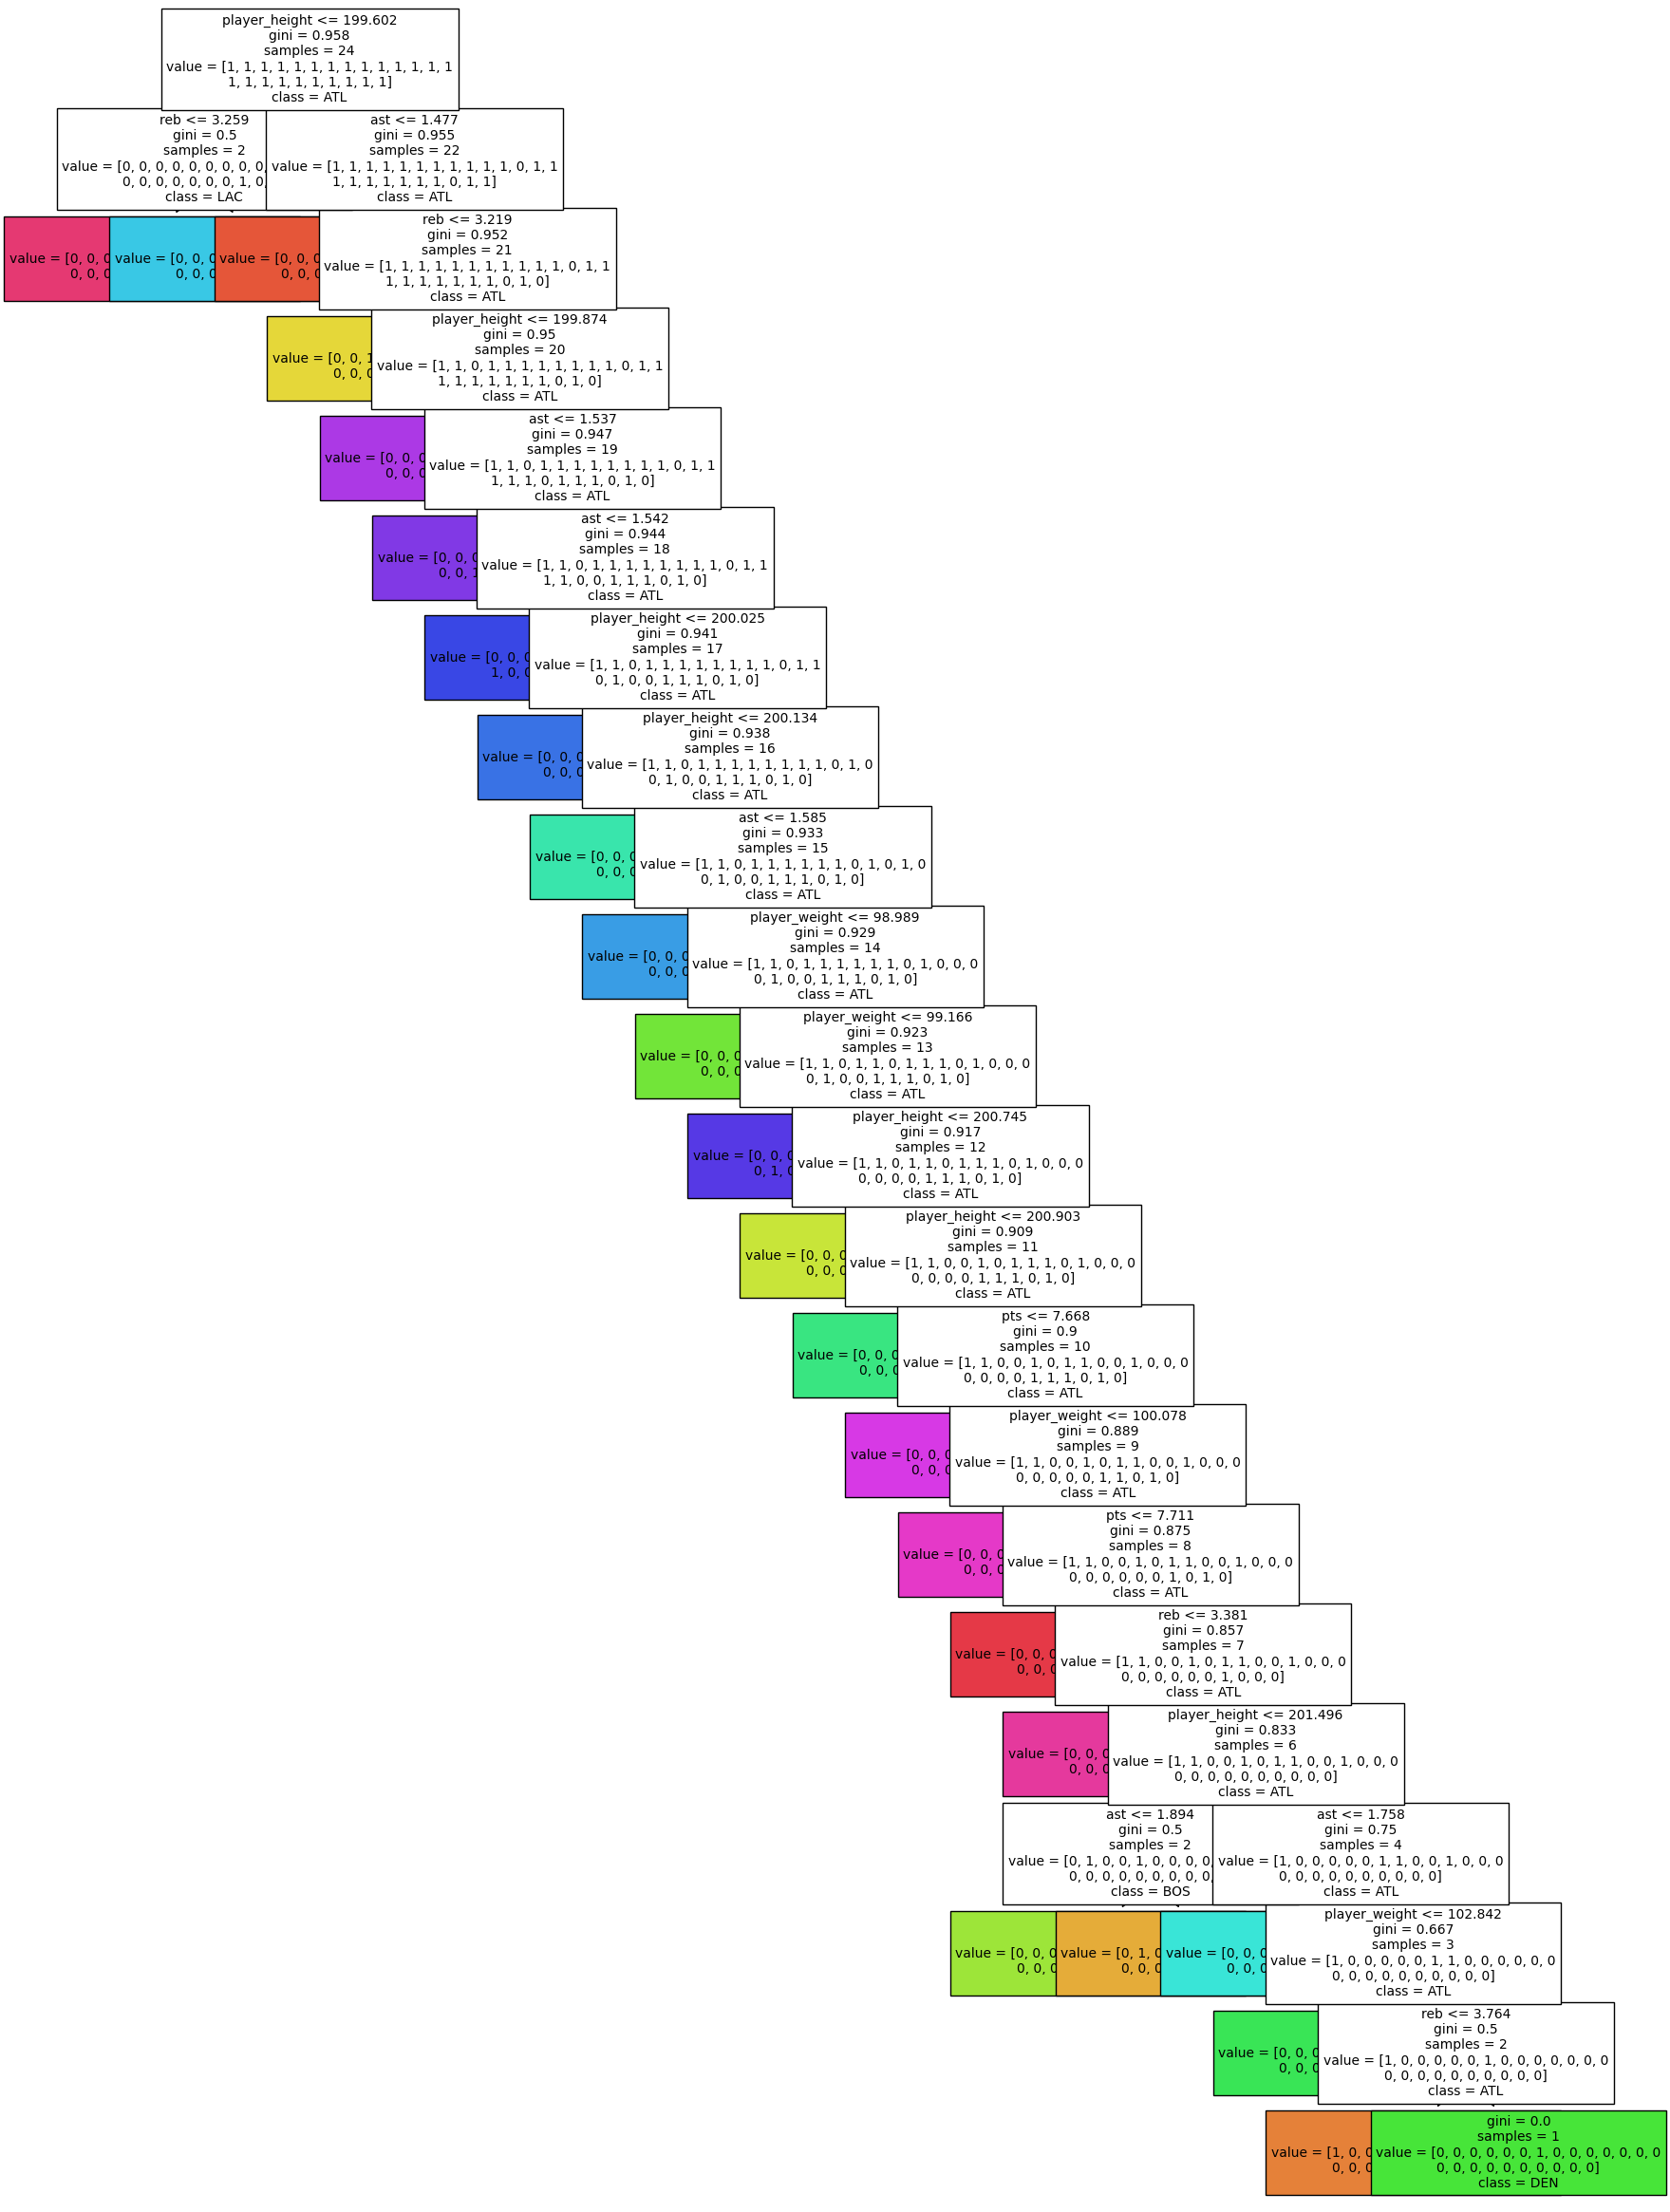

In [172]:
# Построение дерева решений
plt.figure(figsize=(20,30))
plot_tree(dt_classifier, feature_names=X.columns, class_names=Y, filled=True, fontsize=10)
plt.show()

In [173]:
# Сохраняем структуру дерева в файл
dot_data = export_graphviz(dt_classifier, out_file=None,
                           feature_names=X.columns,
                           class_names=Y,
                           filled=True, rounded=True,
                           special_characters=True)

# Построение графа решений
graph = graphviz.Source(dot_data)

# Отображение графа решений
graph.render('decision_tree', format='png', cleanup=True)

'decision_tree.png'

In [174]:
# Предсказание на тестовом наборе
y_pred = dt_classifier.predict(X_test)

# Оценка производительности модели
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.0


## Задание 4.

Используя ваш личный выбор атрибутов на предложенном датасете постройте классификацию данных по любому (любым) атрибутам-признакам

In [175]:
# Выбор атрибутов для классификации
X = df[['age', 'player_height', 'player_weight', 'gp', 'pts', 'reb', 'ast', 'net_rating',
        'oreb_pct', 'dreb_pct', 'usg_pct', 'ts_pct', 'ast_pct']].values
y = df['country']

Проведем масштабирование числовых признаков (атрибутов) и закодируем категориальную переменную `'country'` - воспользуемся методом `LabelEncoder()`

In [176]:
# Масштабирование числовых признаков
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Кодирование категориальной переменной 'country' - LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

В сплит уже подадим предварительно закодированные данные

In [177]:
# Разделение данных на тренировочный и тестовый наборы - переменная y - кодирована LabelEncoder
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

Обучим модель классификации

In [178]:
# Обучение модели классификации методом опорных векторов
svm = SVC(kernel='linear')
svm.fit(X_train, y_train)

# Предсказание меток классов для тестовых данных
y_pred = svm.predict(X_test)

# Оценка точности модели
accuracy = accuracy_score(y_test, y_pred)
print("Точность классификации Метод Опорных Векторов:", accuracy)

Точность классификации Метод Опорных Векторов: 0.8459975619666802


Инвертируем данные `X_test` для визуализации

In [179]:
X_test_inverted = scaler.inverse_transform(X_test)

In [180]:
df_test = pd.DataFrame({'age': X_test_inverted[:, 0],
                        'player_height': X_test_inverted[:, 1],
                        'predicted_country': label_encoder.inverse_transform(y_pred)})

Построение графика на тестовых данных и их предсказанных меток

In [181]:
fig = px.scatter(df_test, x='age', y='player_height', color='predicted_country',
                 labels={'age': 'Возраст',
                         'player_height': 'Рост',
                         'predicted_country': 'Предсказанная страна'},
                 title='Классификация игроков по стране (предсказанные метки)')
fig.show()